# Pipeline for High-z Radio Galaxies 17: Radio detection classification with confirmed and predicted AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

***

## Reading data

In [13]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [14]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [15]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [16]:
mqc_version = '7_4d'  # '7_2'

In [17]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [18]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [19]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [20]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources.

In [21]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [22]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [23]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 30,395 confirmed AGN in this dataset.


In [24]:
# if load_model_flag:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')  # From ML_16.ipynb

Transformation Pipeline and Model Successfully Loaded


In [25]:
AGN_pred_threshold = 0.5
new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                       probability_threshold=AGN_pred_threshold,\
                                       raw_score=True).loc[:, 'Score_1']

In [26]:
full_catalog_df['class'] = new_labels_train.copy()

In [27]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [28]:
AGN_threshold = 0.95
gal_threshold = 0.05

In [29]:
filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [30]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [31]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]

In [32]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'class'] == 0)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 30,509 elements,
30,509 of them are marked as AGN, and, from them, 9,945 have confirmed radio detection.


---

## Possible correlations

In [33]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2', 'class']


---

## Random seed

In [34]:
seed = 42

Create target

In [35]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Remove intermediate targets

In [36]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class'])

## Split data: Test, Train, Validation

In [37]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (30509, 39)
Data for Modeling (Train and Test): (24407, 39)
Unseen Data For Validation: (6102, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [38]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [39]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [40]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [41]:
rsd_vals

z_y             467.796933
i_z             303.709292
r_i             169.705298
radio_detect    143.799594
g_r             143.033659
g_i             111.534328
w1_w2           102.322413
w2_w3            33.934074
band_num         21.882482
J_H              20.816463
H_K              19.989855
w3_w4            16.528940
ymag              5.949269
W1mproPM          5.799108
rmag              5.738020
gmag              5.725873
zmag              5.718551
imag              5.702460
W2mproPM          5.672949
i/K               5.261817
g/J               5.244024
w1/w4             5.157124
r/H               5.137300
w2/w4             5.028223
w1/w3             4.131017
y/W2              3.610473
z/W1              3.510618
W3mag             3.044650
i/y               2.540093
r/z               2.212758
NUVmag            2.175735
Hmag              1.852595
W4mag             1.844690
Jmag              1.797644
FUV/K             1.466093
Kmag              1.319961
FUVmag            0.769096
J

In [42]:
correlation    = norm_train_test_df.corr()

In [43]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [44]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [45]:
target_feat    = 'radio_detect'

In [46]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [47]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [48]:
list_drop_corr

['Jmag',
 'i/K',
 'W2mproPM',
 'w2/w4',
 'Kmag',
 'imag',
 'w1/w4',
 'r/H',
 'g/J',
 'FUV_NUV',
 'gmag',
 'J/K',
 'zmag',
 'w1/w3',
 'W3mag',
 'Hmag',
 'rmag',
 'W1mproPM',
 'g_i']

In [49]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [50]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [51]:
corr_discard = norm_train_test_discard.corr()

In [52]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
w2_w3     ymag        0.735381
z_y       i/y         0.731774
band_num  ymag        0.679966
i_z       r/z         0.665354
ymag      w3_w4       0.637081
FUVmag    NUVmag      0.627645
y/W2      z/W1        0.626535
w2_w3     band_num    0.621843
r/z       r_i         0.596856
H_K       FUV/K       0.552065
w3_w4     NUVmag      0.517440
H_K       ymag        0.516880
w3_w4     w2_w3       0.495561
H_K       w3_w4       0.474314
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

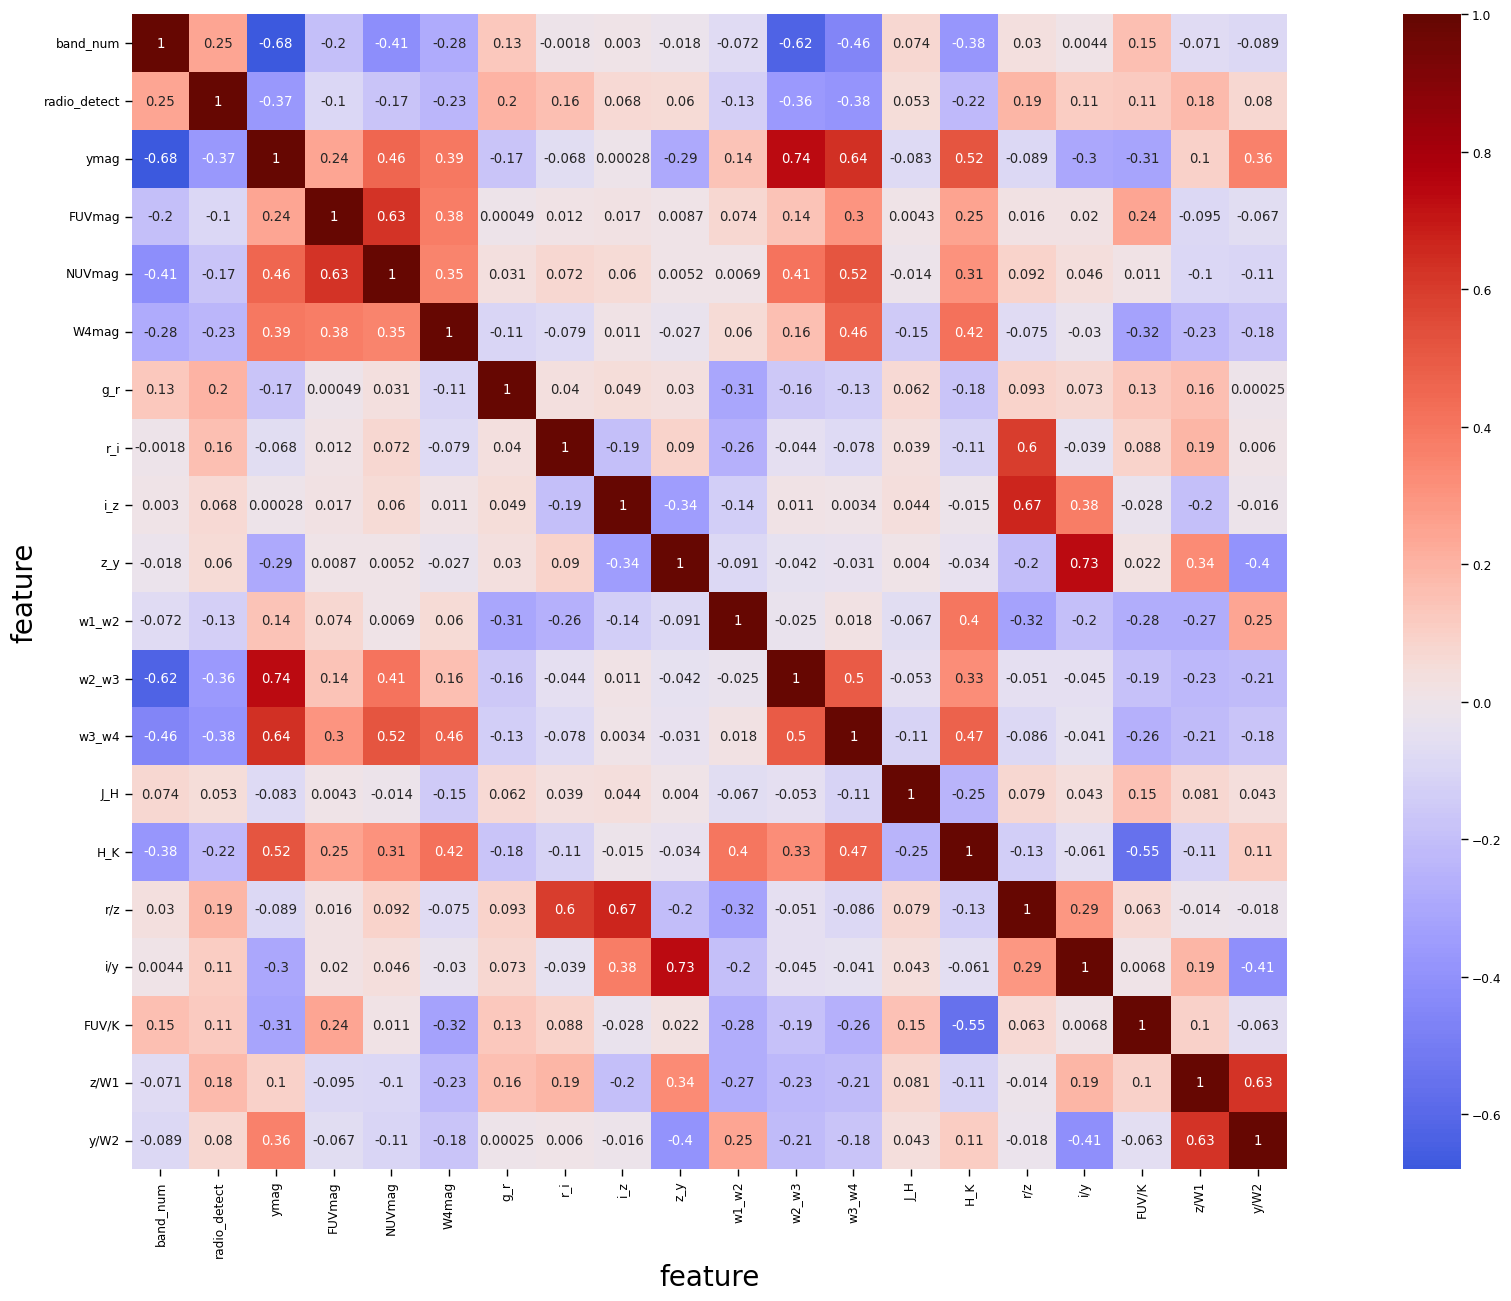

In [53]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [54]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [55]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [56]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
FUV/K     FUV/K           1.000000
          FUVmag          0.494389
band_num  ymag            0.482230
NUVmag    FUVmag          0.322166
band_num  w2_w3           0.309747
w3_w4     radio_detect    0.300853
J_H       H_K             0.283163
ymag      radio_detect    0.257274
z_y       i/y             0.223733
w2_w3     radio_detect    0.214749
band_num  radio_detect    0.206658
ymag      w2_w3           0.203414
          H_K             0.195108
W4mag     radio_detect    0.189536
z_y       ymag            0.184477
band_num  z_y             0.175998
w3_w4     w2_w3           0.173642
w2_w3     ymag            0.167635
FUV/K     H_K             0.157314
i/y       z_y             0.150019
dtype: float64

In [57]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [58]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [59]:
target_feat = 'radio_detect'

In [60]:
list_drop_pps = []

In [61]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [62]:
list_drop_pps

[]

In [63]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [64]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [65]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w3_w4,radio_detect,0.300853,classification,True,weighted F1,0.5444,0.681469,DecisionTreeClassifier()
1,ymag,radio_detect,0.257274,classification,True,weighted F1,0.5444,0.661614,DecisionTreeClassifier()
2,w2_w3,radio_detect,0.214749,classification,True,weighted F1,0.5444,0.642240,DecisionTreeClassifier()
3,band_num,radio_detect,0.206658,classification,True,weighted F1,0.5444,0.638553,DecisionTreeClassifier()
4,W4mag,radio_detect,0.189536,classification,True,weighted F1,0.5444,0.630753,DecisionTreeClassifier()
5,w1_w2,radio_detect,0.144891,classification,True,weighted F1,0.5444,0.610412,DecisionTreeClassifier()
6,r/z,radio_detect,0.122300,classification,True,weighted F1,0.5444,0.600120,DecisionTreeClassifier()
7,H_K,radio_detect,0.121346,classification,True,weighted F1,0.5444,0.599685,DecisionTreeClassifier()
8,J_H,radio_detect,0.120835,classification,True,weighted F1,0.5444,0.599453,DecisionTreeClassifier()
9,z/W1,radio_detect,0.104876,classification,True,weighted F1,0.5444,0.592182,DecisionTreeClassifier()


In [66]:
print(f'{len(full_catalog_df):,}')

30,509


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [67]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('FUVmag')  # After Boruta

In [68]:
feats_2_discard = list_drop_corr + list_drop_pps + ['FUVmag']

Boruta discards one feature.

In [69]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24407, 39)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [70]:
pyc.get_config('X').columns

Index(['band_num', 'ymag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1',
       'y/W2'],
      dtype='object')

In [71]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [72]:
final_selection_clf  = ['dt', 'rf', 'catboost', 'xgboost', 'et', 'dummy']
n_models             = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='Recall')  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda'], sort='Recall')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6767,0.6341,0.5114,0.5041,0.5076,0.2670,0.2671,0.3960
rf,Random Forest Classifier,0.7698,0.7966,0.5089,0.7032,0.5903,0.4360,0.4471,0.9590
catboost,CatBoost Classifier,0.7711,0.8038,0.5076,0.7078,0.5910,0.4380,0.4498,3.8100
xgboost,Extreme Gradient Boosting,0.7616,0.7858,0.5040,0.6827,0.5795,0.4185,0.4281,19.5610
et,Extra Trees Classifier,0.7642,0.7936,0.4936,0.6950,0.5771,0.4201,0.4320,0.3610
dummy,Dummy Classifier,0.6740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0240


Thus, we select `dt` as meta learner.

Thus, we stack the models.

In [73]:
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0], optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6630,0.6148,0.4758,0.4827,0.4792,0.2301,0.2301
1,0.6758,0.6275,0.4865,0.5028,0.4945,0.2560,0.2561
2,0.6910,0.6610,0.5709,0.5239,0.5464,0.3128,0.3135
3,0.6928,0.6559,0.5458,0.5278,0.5366,0.3070,0.3071
4,0.6862,0.6409,0.5090,0.5183,0.5136,0.2820,0.2820
5,0.6786,0.6390,0.5314,0.5068,0.5188,0.2777,0.2779
6,0.6751,0.6318,0.5063,0.5018,0.5040,0.2624,0.2624
7,0.6715,0.6355,0.5314,0.4966,0.5134,0.2660,0.2663
8,0.6645,0.6186,0.4829,0.4856,0.4842,0.2357,0.2357


In [74]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='Recall',\
                                 search_library='tune-sklearn', search_algorithm='random')  # 1h30

(_Trainable pid=3031) /home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
(_Trainable pid=3031)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
Trial _Trainable_4bbe9_00000: Error processing event.


RayTaskError(ValueError): [36mray::_Trainable.train()[39m (pid=3053, ip=194.117.9.85, repr=<tune_sklearn._trainable._Trainable object at 0x7fc525b65970>)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/ray/tune/trainable.py", line 315, in train
    result = self.step()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 106, in step
    return self._train()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 237, in _train
    scores = cross_validate(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 436, in fit
    return super().fit(X, self._le.transform(y), sample_weight)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 195, in fit
    _fit_single_estimator(self.final_estimator_, X_meta, y,
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_base.py", line 40, in _fit_single_estimator
    estimator.fit(X, y)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 255, in fit
    raise ValueError("Invalid value for max_features. "
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.

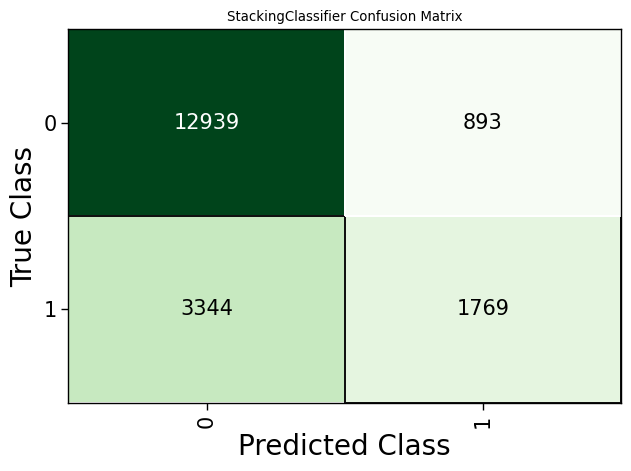

In [82]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

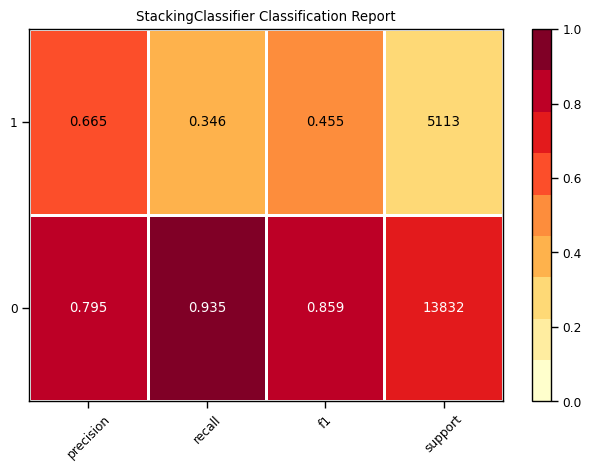

In [83]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

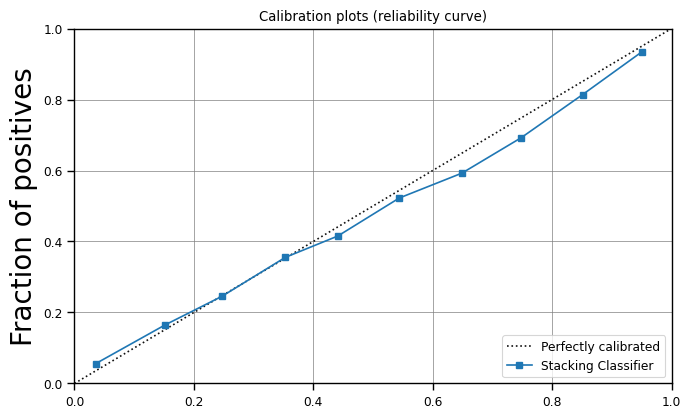

In [84]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

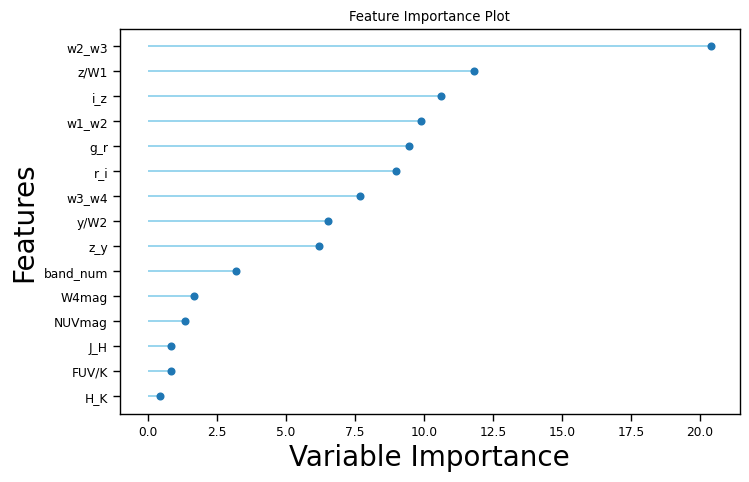

In [85]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [87]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.05
max_depth,-1
min_child_samples,56
min_child_weight,0.001
min_split_gain,0.3
n_estimators,210


In [88]:
plt.rcParams.update(plt.rcParamsDefault)

In [89]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7764,0.7849,0.3460,0.6645,0.4550,0.3315,0.3595


,band_num,NUVmag,W4mag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,w3_w4,J_H,H_K,FUV/K,z/W1,y/W2,radio_detect,Label,Score_0,Score_1
0,-1.050801,0.259998,0.185214,-0.305500,-0.215556,1.252056,1.067637,0.104266,0.976778,0.277645,-0.011376,0.101317,-0.019187,0.790677,0.041159,0,0,0.8286,0.1714
1,1.026254,-3.900047,0.185214,0.032185,-1.282960,-0.273363,-0.372774,0.557954,-1.270124,0.277645,-0.011376,0.101317,-0.019187,0.162244,0.691514,0,0,0.7260,0.2740
2,-1.050801,0.259998,0.185214,-0.305500,-0.215556,1.252056,1.067637,0.173997,0.923049,0.277645,-0.011376,0.101317,-0.019187,0.790677,0.065738,0,0,0.7755,0.2245
3,0.255436,0.259998,0.185214,0.952485,-0.583823,-0.589107,-1.326584,-0.947149,0.417559,0.277645,-0.011376,0.101317,-0.019187,-0.325383,0.324092,0,0,0.8499,0.1501
4,0.255436,0.259998,0.185214,0.328224,0.071370,0.357853,-1.518679,-1.828882,-0.682370,0.277645,-0.011376,0.101317,-0.019187,0.601245,1.249617,0,0,0.7229,0.2771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18940,-1.050801,0.259998,0.185214,-0.305500,-0.215556,1.252056,1.067637,-1.335939,1.034725,0.277645,-0.011376,0.101317,-0.019187,1.254628,0.015170,1,0,0.7223,0.2777
18941,-1.050801,0.259998,0.185214,0.399260,0.156341,-0.430961,-1.054631,-0.144882,0.574933,0.277645,-0.011376,0.101317,-0.019187,-0.468598,0.237754,0,0,0.8706,0.1294
18942,1.026254,0.259998,0.185214,-0.226043,0.007159,-0.693368,-0.202629,0.200360,-0.741719,0.277645,-0.011376,0.101317,-0.019187,-1.242998,-1.147241,1,0,0.7288,0.2712
18943,0.632219,0.259998,0.185214,-0.456816,-0.372317,-0.468736,0.368215,1.044753,0.353221,0.277645,-0.011376,0.101317,-0.019187,-1.334211,-1.435273,0,0,0.9505,0.0495


In [90]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7764,0.7849,0.3460,0.6645,0.4550,0.3315,0.3595


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [91]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [92]:
if save_model_flag:
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_14_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_may_14_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_radio_clf = pyc.load_model('models/classification_radio_detect_may_14_2022')

### Prediction process

#### Feature importances

In [93]:
estimators_list = [estimator[0] for estimator in final_radio_clf.estimators]

In [94]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_radio = extended_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [95]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [96]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [97]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [98]:
base_models_names = [model[0] for model in estimators_list]

In [99]:
coef_sorted_base_df = {}

In [100]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [101]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [102]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for gbc...
Calculating for ada...
Calculating for xgboost...


catboost                  gbc                  ada              xgboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w2_w3  21.686947     w3_w4  37.979357     w2_w3       24.0     w3_w4   
1       z/W1  11.813289     w2_w3  35.423452      z/W1       14.0     W4mag   
2        i_z  11.082586       i_z   7.019229       r_i       10.0     w2_w3   
3      w1_w2   9.611492      z/W1   4.915963       i_z       10.0       i_z   
4        g_r   9.252906       r_i   3.345193     w3_w4       10.0      z/W1   
5        r_i   8.548600     w1_w2   3.105621     w1_w2        8.0    NUVmag   
6      w3_w4   7.691575       g_r   3.043971       g_r        6.0       r_i   
7       y/W2   6.309658     W4mag   2.778690      y/W2        6.0       g_r   
8        z_y   5.515532      y/W2   1.320640  band_num        4.0     w1_w2   
9   band_num   3.394886  band_num   0.410109     W4mag        2.0  band_num   
10     W4mag   1.831746       z_y   0.292853       z_y        2.0      y/W2   
11    NUVmag   1.003649    NUVmag   0.208011       H_K        2.0       z_y   
12     FUV/K   0.902439     FUV/K   0.103418     FUV/K        2.0     FUV/K   
13       J_H   0.777726       H_K   0.048126    NUVmag        0.0       H_K   
14       H_K   0.576967       J_H   0.005368       J_H        0.0       J_H   

               
   Importance  
0   32.667248  
1   19.091373  
2   16.435974  
3    4.137479  
4    3.844109  
5    3.106658  
6    2.967183  
7    2.838032  
8    2.817326  
9    2.662046  
10   2.496261  
11   2.222663  
12   1.947456  
13   1.655511  
14   1.110678

In [103]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,r_i,8.999310
1,xgboost,8.812974
2,g_r,8.730159
3,catboost,8.626639
4,w1_w2,8.571429
5,z/W1,8.467909
6,i_z,8.198758
7,ada,7.253278
8,w2_w3,7.163561
9,gbc,6.970324


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w2_w3	21.792
z/W1	11.690
i_z	10.965
w1_w2	9.467
g_r	9.099
r_i	8.458
w3_w4	8.251
y/W2	6.221
z_y	5.399
band_num	3.365
W4mag	2.010
NUVmag	1.007
FUV/K	0.915
J_H	0.766
H_K	0.596


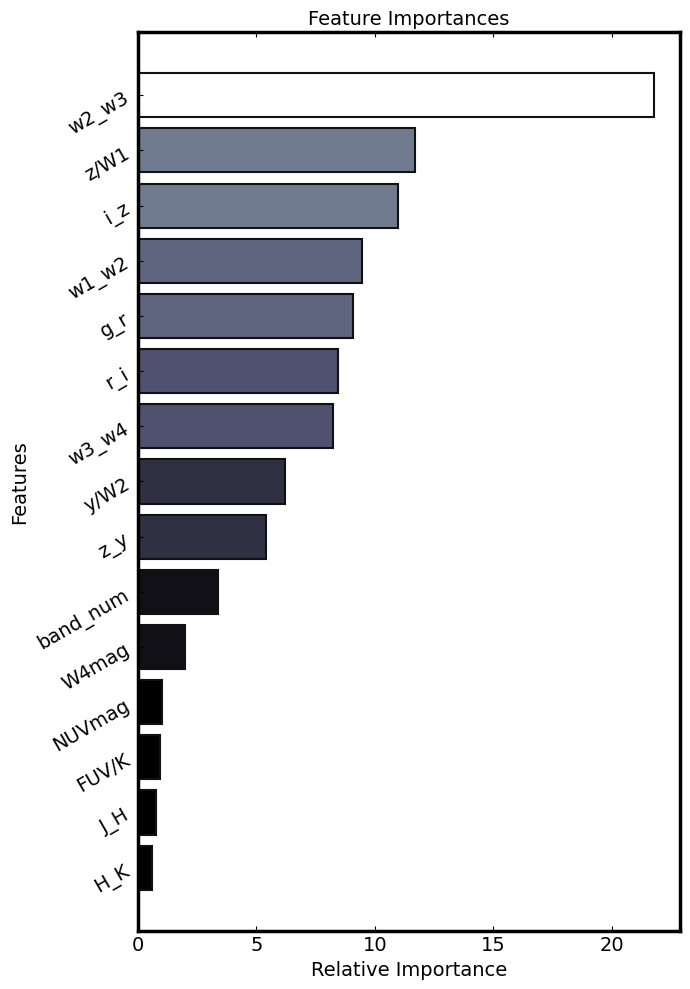

In [104]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [105]:
radio_pred_threshold = 0.5
# radio_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [106]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7806,0.7938,0.3412,0.6888,0.4564,0.3380,0.3707


Create confusion matrix with validation data.

In [107]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

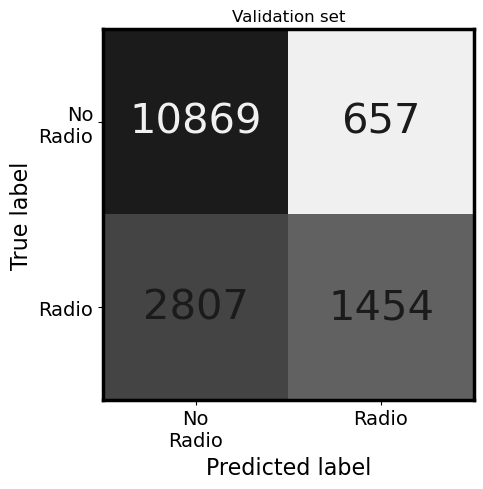

In [108]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_04.pdf', bbox_inches='tight')
plt.show()

In [109]:
# TN_radio, FP_radio, FN_radio, TP_radio = cm_mat_val.flatten().astype('float32')

In [110]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [111]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.3707
Accuracy is                         ACC = 0.7806
F1-score is                          F1 = 0.4564
Recall is                           TPR = 0.3412


---

### Separate AGN and galaxies for Confusion Matrices

In [112]:
# validation_prediction_clf_AGN = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 1]
# validation_prediction_clf_gal = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 0]

In [113]:
# cm_mat_val_gal = np.array([[np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 1))]])
# 
# cm_mat_val_AGN = np.array([[np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 1))]])

In [114]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
# 
# plot_conf_mat(cm_mat_val_gal, title='Galaxies', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_gal_03.pdf', bbox_inches='tight')
# plt.show()

In [115]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
#  
# plot_conf_mat(cm_mat_val_AGN, title='AGN', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_AGN_03.pdf', bbox_inches='tight')
# plt.show()

In [116]:
# TN_radio_gal, FP_radio_gal, FN_radio_gal, TP_radio_gal = cm_mat_val_gal.flatten().astype('float32')
# TN_radio_AGN, FP_radio_AGN, FN_radio_AGN, TP_radio_AGN = cm_mat_val_AGN.flatten().astype('float32')

In [117]:
# MCC_radio_val_gal = ((TP_radio_gal * TN_radio_gal) - (FP_radio_gal * FN_radio_gal)) /\
#             np.sqrt((TP_radio_gal + FP_radio_gal) * (TP_radio_gal + FN_radio_gal) * (TN_radio_gal + FP_radio_gal) * (TN_radio_gal + FN_radio_gal))
# 
# ACC_radio_val_gal = (TP_radio_gal + TN_radio_gal) / (TP_radio_gal + TN_radio_gal + FP_radio_gal + FN_radio_gal)
# 
# F1_radio_val_gal  = 2 * TP_radio_gal / (2 * TP_radio_gal + FP_radio_gal + FN_radio_gal)
# 
# Recall_radio_val_gal = TP_radio_gal / (TP_radio_gal + FN_radio_gal)

In [118]:
# MCC_radio_val_AGN = ((TP_radio_AGN * TN_radio_AGN) - (FP_radio_AGN * FN_radio_AGN)) /\
#             np.sqrt((TP_radio_AGN + FP_radio_AGN) * (TP_radio_AGN + FN_radio_AGN) * (TN_radio_AGN + FP_radio_AGN) * (TN_radio_AGN + FN_radio_AGN))
# 
# ACC_radio_val_AGN = (TP_radio_AGN + TN_radio_AGN) / (TP_radio_AGN + TN_radio_AGN + FP_radio_AGN + FN_radio_AGN)
# 
# F1_radio_val_AGN  = 2 * TP_radio_AGN / (2 * TP_radio_AGN + FP_radio_AGN + FN_radio_AGN)
# 
# Recall_radio_val_AGN = TP_radio_AGN / (TP_radio_AGN + FN_radio_AGN)

In [119]:
# print('Metrics for galaxies in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_gal:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_gal:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_gal:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_gal:.4f}')

In [120]:
# print('Metrics for AGN in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_AGN:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_AGN:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_AGN:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_AGN:.4f}')

---

In [121]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [122]:
train_prediction_clf = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8054,0.8415,0.3908,0.7781,0.5203,0.4146,0.4533


In [123]:
test_prediction_clf = pyc.predict_model(final_radio_clf, data=test_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8027,0.8395,0.3870,0.7647,0.5139,0.4064,0.4435


In [124]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [125]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

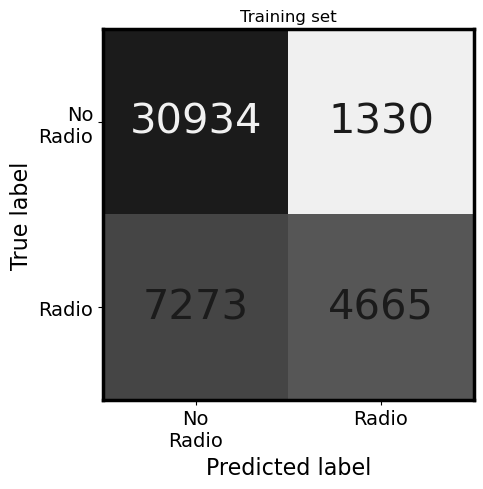

In [126]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_04.pdf', bbox_inches='tight')
plt.show()

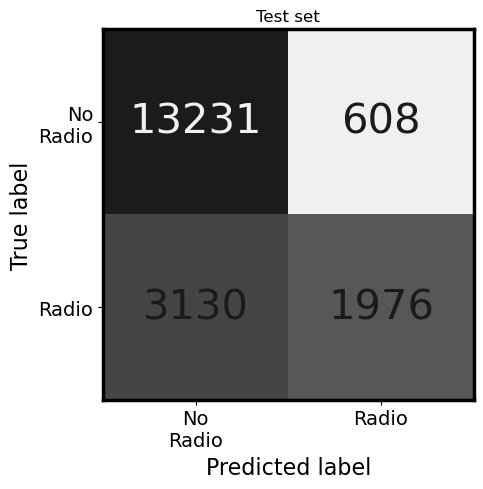

In [127]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_04.pdf', bbox_inches='tight')
plt.show()

In [128]:
# TN_radio_train, FP_radio_train, FN_radio_train, TP_radio_train = cm_mat_train.flatten().astype('float32')

In [129]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [130]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.4533
Accuracy is                         ACC = 0.8054
F1-score is                          F1 = 0.5203
Recall is                           TPR = 0.3908


In [131]:
# TN_radio_test, FP_radio_test, FN_radio_test, TP_radio_test = cm_mat_test.flatten().astype('float32')

In [132]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [133]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.4435
Accuracy is                         ACC = 0.8027
F1-score is                          F1 = 0.5139
Recall is                           TPR = 0.3870


Calculate ROC AUC values and plots.

In [134]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [135]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.84152
Area under the curve (ROC) for test       = 0.83945
Area under the curve (ROC) for validation = 0.79377


In [136]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

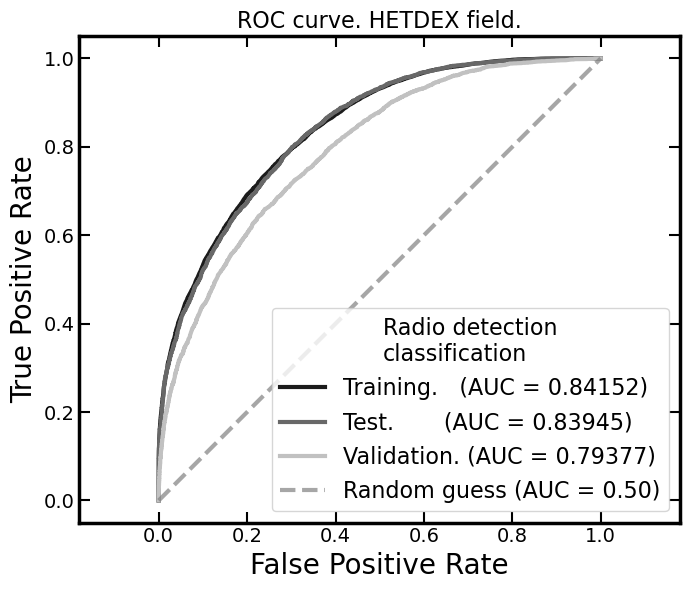

In [137]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_04.pdf', bbox_inches='tight')
plt.show()